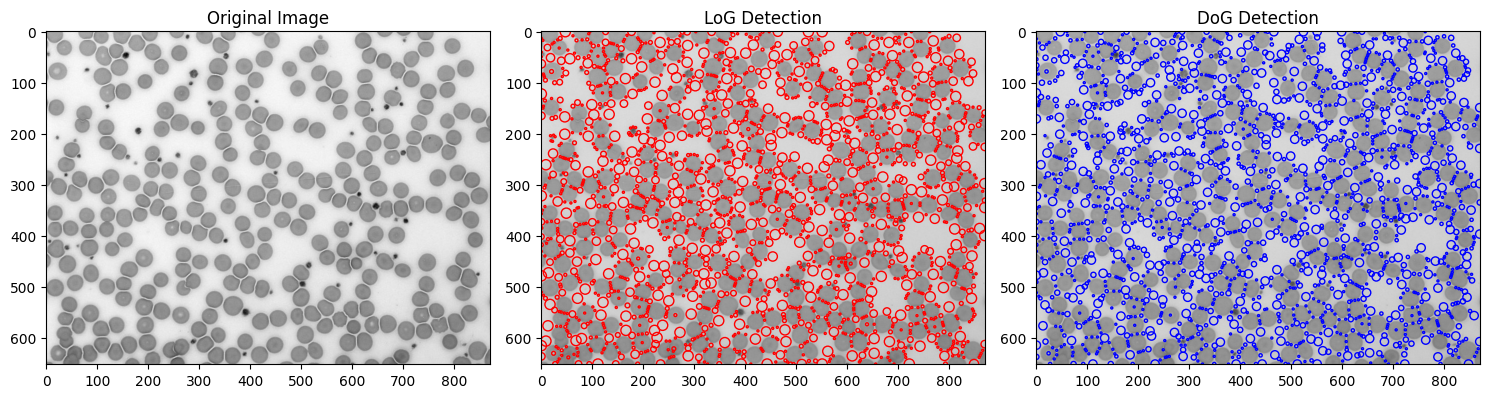

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_log, blob_dog
from skimage import color


image_path = "/content/Picture2.jpg"  # Update with your file path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

#(LoG)
blobs_log = blob_log(image, min_sigma=2, max_sigma=10, num_sigma=10, threshold=0.02)

# (DoG)
blobs_dog = blob_dog(image, min_sigma=2, max_sigma=10, threshold=0.02)

# Convert to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original Image
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")

# LoG Result
axes[1].imshow(image_rgb)
axes[1].set_title("LoG Detection")
for blob in blobs_log:
    y, x, r = blob
    circle = plt.Circle((x, y), r, color='red', linewidth=1, fill=False)
    axes[1].add_patch(circle)

# DoG Result
axes[2].imshow(image_rgb)
axes[2].set_title("DoG Detection")
for blob in blobs_dog:
    y, x, r = blob
    circle = plt.Circle((x, y), r, color='blue', linewidth=1, fill=False)
    axes[2].add_patch(circle)

plt.tight_layout()
plt.show()


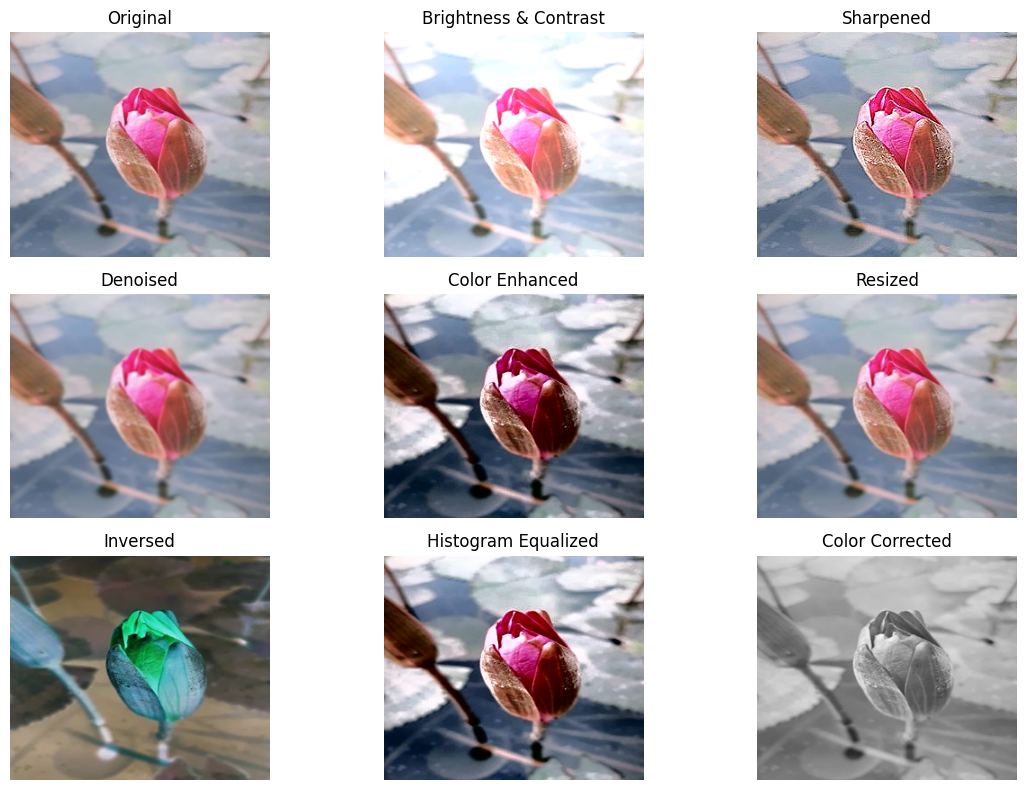

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = "Picture1.jpg"
image = cv2.imread(image_path)

#adjust brightness and contrast
def adjust_brightness_contrast(img, alpha=1.2, beta=30):
    return cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

#sharpening
def sharpen_image(img):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

#remove noise using Gaussian Blur
def remove_noise(img):
    return cv2.GaussianBlur(img, (5, 5), 0)

#enhance color
def enhance_color(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l = cv2.equalizeHist(l)
    enhanced_lab = cv2.merge((l, a, b))
    return cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

#resize image
def resize_image(img, scale=1.5):
    width = int(img.shape[1] * scale)
    height = int(img.shape[0] * scale)
    return cv2.resize(img, (width, height))

#inverse transformation
def inverse_transform(img):
    return cv2.bitwise_not(img)

# Function to apply histogram equalization
def histogram_equalization(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

# Apply Super-Resolution (Using OpenCV DNN)
def super_resolution(img):
    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    sr.readModel("EDSR_x3.pb")  # Use a pre-trained model
    sr.setModel("edsr", 3)
    return sr.upsample(img)

#color correction
def color_correction(img):
    result = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)

#Apply enhancements
bright_contrast = adjust_brightness_contrast(image)
sharpened = sharpen_image(image)
denoised = remove_noise(image)
color_enhanced = enhance_color(image)
resized = resize_image(image, scale=1.5)
inversed = inverse_transform(image)
hist_eq = histogram_equalization(image)
color_corrected = color_correction(image)


titles = ["Original", "Brightness & Contrast", "Sharpened", "Denoised", "Color Enhanced",
          "Resized", "Inversed", "Histogram Equalized", "Color Corrected"]
images = [image, bright_contrast, sharpened, denoised, color_enhanced,
          resized, inversed, hist_eq, color_corrected]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import time
from torchvision import models

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for CIFAR-100
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load a subset of CIFAR-100 (first 10 classes only)
class_subset = list(range(10))
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainset = torch.utils.data.Subset(trainset, [i for i in range(len(trainset)) if trainset[i][1] in class_subset])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testset = torch.utils.data.Subset(testset, [i for i in range(len(testset)) if testset[i][1] in class_subset])
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Function to load model with mixed precision
def load_model(model_name):
    if model_name == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    elif model_name == "resnet34":
        model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

    model.fc = nn.Linear(model.fc.in_features, len(class_subset))  # Adjust for subset classes
    return model.to(device)

# Function to train model
def train_model(model, criterion, optimizer, epochs=3):  # Reduced epochs
    scaler = torch.cuda.amp.GradScaler()  # Mixed precision training
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")
    print("Training Completed!")

# Function to evaluate model
def evaluate_model(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Train and evaluate ResNet-18
model_18 = load_model("resnet18")
criterion = nn.CrossEntropyLoss()
optimizer_18 = optim.SGD(model_18.parameters(), lr=0.01, momentum=0.9)  # Faster optimizer
start_time = time.time()
train_model(model_18, criterion, optimizer_18, epochs=3)
evaluate_model(model_18)
print(f"ResNet-18 Training Time: {time.time() - start_time:.2f} sec")

# Train and evaluate ResNet-34
model_34 = load_model("resnet34")
optimizer_34 = optim.SGD(model_34.parameters(), lr=0.01, momentum=0.9)  # Faster optimizer
start_time = time.time()
train_model(model_34, criterion, optimizer_34, epochs=3)
evaluate_model(model_34)
print(f"ResNet-34 Training Time: {time.time() - start_time:.2f} sec")

<ipython-input-1-e274a086b2e1>:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Mixed precision training
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
<ipython-input-1-e274a086b2e1>:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1, Loss: 1.2828
Epoch 2, Loss: 0.9784
Epoch 3, Loss: 0.8990
Training Completed!
Accuracy: 66.60%
ResNet-18 Training Time: 167.47 sec


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 83.3M/83.3M [00:00<00:00, 138MB/s]


Epoch 1, Loss: 1.1970
Epoch 2, Loss: 1.2119
Epoch 3, Loss: 1.0413
Training Completed!
Accuracy: 50.50%
ResNet-34 Training Time: 312.39 sec



ðŸ“Š Performance of ResNet-18:
              precision    recall  f1-score   support

           0     0.6296    0.8500    0.7234       100
           1     0.7789    0.7400    0.7590       100
           2     0.5743    0.5800    0.5771       100
           3     0.6735    0.3300    0.4430       100
           4     0.6806    0.4900    0.5698       100
           5     0.7419    0.6900    0.7150       100
           6     0.4749    0.8500    0.6093       100
           7     0.6733    0.6800    0.6766       100
           8     0.9221    0.7100    0.8023       100
           9     0.7551    0.7400    0.7475       100

    accuracy                         0.6660      1000
   macro avg     0.6904    0.6660    0.6623      1000
weighted avg     0.6904    0.6660    0.6623      1000



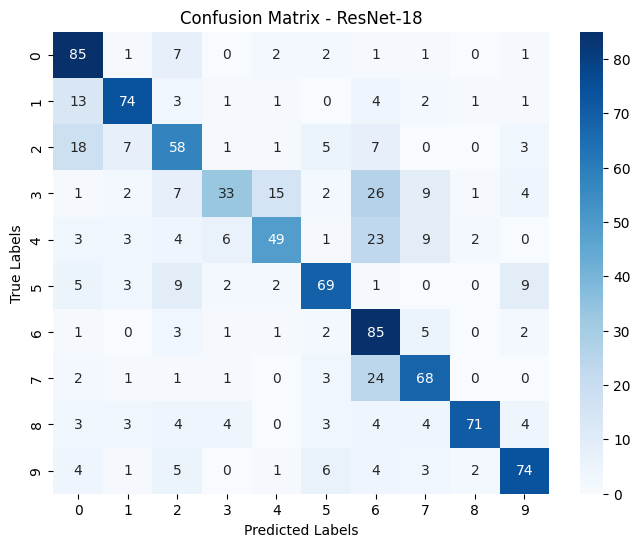


ðŸ“Š Performance of ResNet-34:
              precision    recall  f1-score   support

           0     0.5741    0.3100    0.4026       100
           1     0.8831    0.6800    0.7684       100
           2     0.3475    0.4900    0.4066       100
           3     0.7143    0.1500    0.2479       100
           4     0.2826    0.3900    0.3277       100
           5     0.8718    0.3400    0.4892       100
           6     0.5914    0.5500    0.5699       100
           7     0.5130    0.5900    0.5488       100
           8     0.6336    0.8300    0.7186       100
           9     0.3770    0.7200    0.4948       100

    accuracy                         0.5050      1000
   macro avg     0.5788    0.5050    0.4975      1000
weighted avg     0.5788    0.5050    0.4975      1000



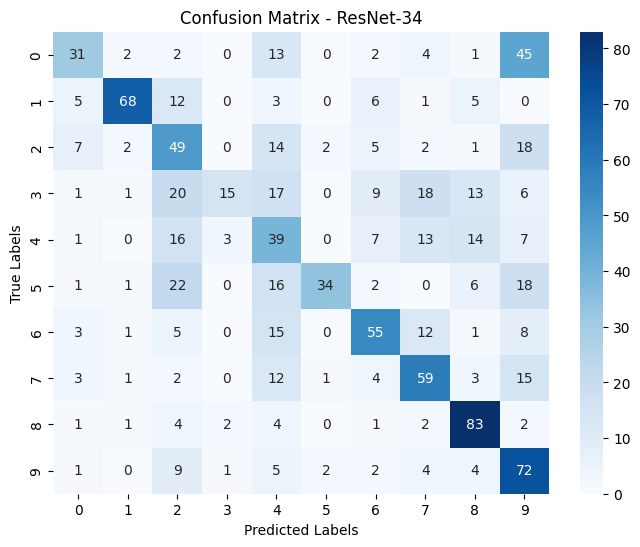

In [ ]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to compute evaluation metrics
def evaluate_metrics(model, dataloader, model_name):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute classification metrics
    print(f"\nðŸ“Š Performance of {model_name}:")
    print(classification_report(all_labels, all_preds, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_subset, yticklabels=class_subset)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Evaluate ResNet-18
evaluate_metrics(model_18, testloader, "ResNet-18")

# Evaluate ResNet-34
evaluate_metrics(model_34, testloader, "ResNet-34")
